In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
import numpy as np

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import squarify

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from yellowbrick.cluster import KElbowVisualizer
#always remember your magic function if using Jupyter
%matplotlib inline


%pylab inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
os.chdir('/Users/alexandrejacqueline/Data_Science/P5_DATA')

customer_df     = pd.read_csv('customer_df.csv', sep=',')
data      = pd.read_csv('data.csv', sep=',')

Populating the interactive namespace from numpy and matplotlib


## Fonctions

In [2]:
# Fonction pour vérifier l'asymétrie
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return


In [3]:
# Function to visualize clusters
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': ['mean', 'count']
        }).round(0)

    return df_new

## Data

In [4]:
customer_df["order_purchase_timestamp"] = pd.to_datetime(customer_df["order_purchase_timestamp"])
#data.drop(["Unnamed: 0"],axis=1,inplace=True)
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])


    #le jour de la semaine
jour_achat = customer_df[['customer_unique_id','order_purchase_timestamp']].groupby(['customer_unique_id']).head(5)
jour_achat['order_purchase_timestamp'] = jour_achat['order_purchase_timestamp'].astype('datetime64')
jour_achat['jour_achat'] = jour_achat['order_purchase_timestamp'].apply(lambda x: x.weekday())
jour_achat = jour_achat.drop(['order_purchase_timestamp'],axis=1)

    
    #heure achat
    
heure_achat = customer_df[['customer_unique_id','order_purchase_timestamp']].groupby(['customer_unique_id']).head(5)
heure_achat['order_purchase_timestamp'] = heure_achat['order_purchase_timestamp'].astype('datetime64')
heure_achat['heure_de_achat'] = heure_achat['order_purchase_timestamp'].apply(lambda x: x.hour)
heure_achat = heure_achat.drop(['order_purchase_timestamp'],axis=1)

    
customer_df['heure_achat'] = heure_achat['heure_de_achat']
customer_df['jour_achat'] = jour_achat['jour_achat']
customer_df['Total_Payment']  = customer_df['payment_value']  +  customer_df['freight_value']
customer_df.drop(["Unnamed: 0"],axis=1,inplace=True)

## RFM

In [5]:
amount = pd.DataFrame(customer_df.nb_order * customer_df.payment_value + customer_df.freight_value, columns = ["Amount"])


customer_df_df = pd.concat(objs = [customer_df, amount], axis = 1 ,  ignore_index = False)
customer_df_df["order_purchase_timestamp"] = pd.to_datetime(customer_df_df["order_purchase_timestamp"])
monetary = customer_df_df.groupby("customer_unique_id").Amount.sum()
monetary = monetary.reset_index()



master = customer_df_df[["customer_unique_id","nb_order" , "Amount"]]

recency = customer_df_df[["customer_unique_id","order_purchase_timestamp"]]
#customer_df_df["order_purchase_timestamp"] = pd.to_datetime(customer_df_df["order_purchase_timestamp"])

maximum = max(customer_df_df.order_purchase_timestamp)

# Ajout d'un jour supplémentaire aux données max, de sorte que la date max aura 1 comme différence et non zéro
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.order_purchase_timestamp


a = recency.groupby('customer_unique_id')

#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('customer_unique_id')['diff'].min())
df = df.reset_index()
df.columns = ["customer_unique_id", "Recency"]


#Combining all recency, frequency and monetary parameters
RFM = recency.merge(monetary, on = "customer_unique_id")
RFM = RFM.merge(df, on = "customer_unique_id")


RFM = RFM.merge(customer_df, on = "customer_unique_id")

RFM = RFM[["customer_unique_id","nb_order","Amount","Recency"]]

RFM = RFM.rename({"customer_unique_id":"CustomerID",'nb_order': 'Frequency'}, axis=1)

In [6]:
"""# standardise all parameters
RFM_norm1 = RFM.drop(["CustomerID"], axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)"""

'# standardise all parameters\nRFM_norm1 = RFM.drop(["CustomerID"], axis=1)\nRFM_norm1.Recency = RFM_norm1.Recency.dt.days\n\nfrom sklearn.preprocessing import StandardScaler\nstandard_scaler = StandardScaler()\nRFM_norm1 = standard_scaler.fit_transform(RFM_norm1)'

In [7]:
# select the float columns
data_num = customer_df.select_dtypes(include=[np.float, np.int])

## RFM + KMEAN

In [134]:
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])

df_recency = data.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()

df_recency.rename(columns={"order_purchase_timestamp":"LastPurchaseDate"}, inplace=True)
df_recency["LastPurchaseDate"] = df_recency["LastPurchaseDate"].dt.date

recent_date = data['order_purchase_timestamp'].dt.date.max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)

# Calculating frequency
frequency_df = data.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)
frequency_df.head()

# Calculating monetray value
monetary_df = data.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']
monetary_df.head()

# Merging dfs
rf_df = df_recency.merge(frequency_df, on='customer_unique_id')
rfm_df = rf_df.merge(monetary_df, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm_df.head()

# Remove zeros from data before log trans
rfm_df[rfm_df.columns[1:]] = rfm_df[rfm_df.columns[1:]].applymap(lambda x: 1 if x ==0 else x)



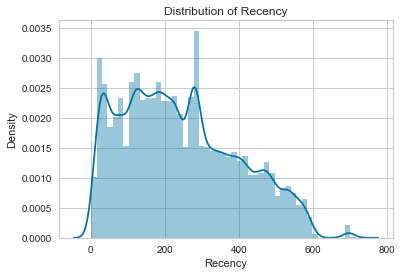

Recency's: Skew: 0.4525743664936904, : SkewtestResult(statistic=53.91755466635981, pvalue=0.0)


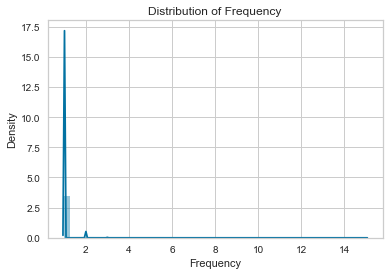

Frequency's: Skew: 10.990942154921314, : SkewtestResult(statistic=335.6456861541721, pvalue=0.0)


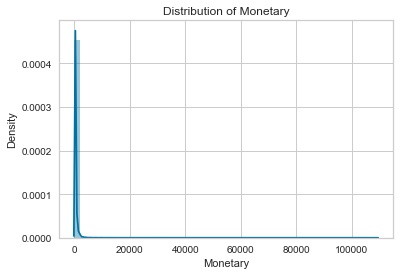

Monetary's: Skew: 70.33621193560055, : SkewtestResult(statistic=524.6379205104615, pvalue=0.0)


In [135]:
# Running K-Means algo to cluster our data
for col in rfm_df.columns[1:]:
    check_skew(rfm_df, col)

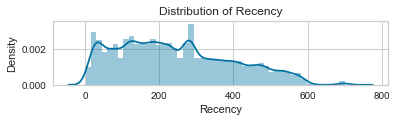

Recency's: Skew: 0.4525743664936904, : SkewtestResult(statistic=53.91755466635981, pvalue=0.0)


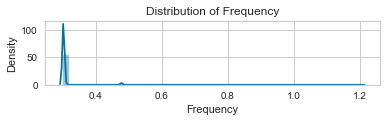

Frequency's: Skew: 6.484023158484742, : SkewtestResult(statistic=282.13674126167024, pvalue=0.0)


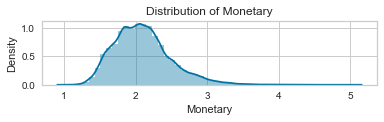

Monetary's: Skew: 0.7512132413897934, : SkewtestResult(statistic=83.91736701659367, pvalue=0.0)


In [136]:
# Perform log transformation 
rfm_df_log = rfm_df.copy()
for c in rfm_df.columns[2:]:
    rfm_df_log[c] = np.log10(rfm_df_log[c]+1)
    
    
for col in rfm_df.columns[1:]:
    plt.subplot(3,1,1)
    check_skew(rfm_df_log,col) 

In [293]:
rfm_df_log.shape

(93396, 4)

In [294]:
scaler = StandardScaler()
scaler.fit(rfm_df_log.drop("customer_unique_id", axis=1))
RFM_Table_scaled = scaler.transform(rfm_df_log.drop("customer_unique_id", axis=1))
# Put data into a df
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=rfm_df_log.columns[1:])
RFM_Table_scaled.shape

(93396, 3)

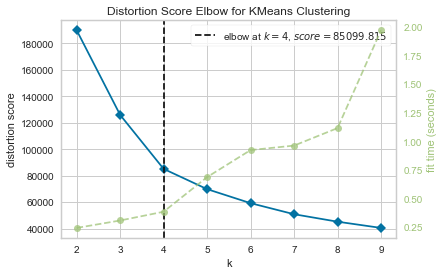

In [138]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(RFM_Table_scaled)
visualizer.show()
plt.show()

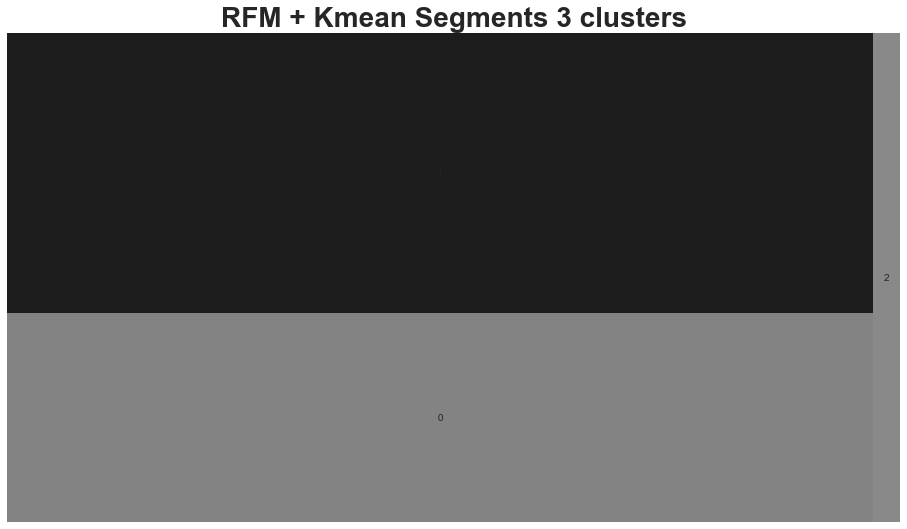

In [139]:
rfm_df_3 = rfm_df.copy()

# 3 clusters
kmean_model_3 = KMeans(n_clusters=3, random_state=5)
kmean_y_3 = kmean_model_3.fit_predict(RFM_Table_scaled)
# Add labels to df
rfm_df_3['Cluster'] = kmean_model_3.labels_

FMCG_rfm_level_agg_3  = rfm_df_3.groupby(['Cluster']).agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': ['mean', 'count']
        }).round(0)

FMCG_rfm_level_agg_3.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=FMCG_rfm_level_agg_3['Count'], 
              label=['0',
                     '1',
                     '2',
                     ], alpha=0.9 )
plt.title("RFM + Kmean Segments 3 clusters",fontsize=28,fontweight="bold")
plt.axis('off')
plt.show()

<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

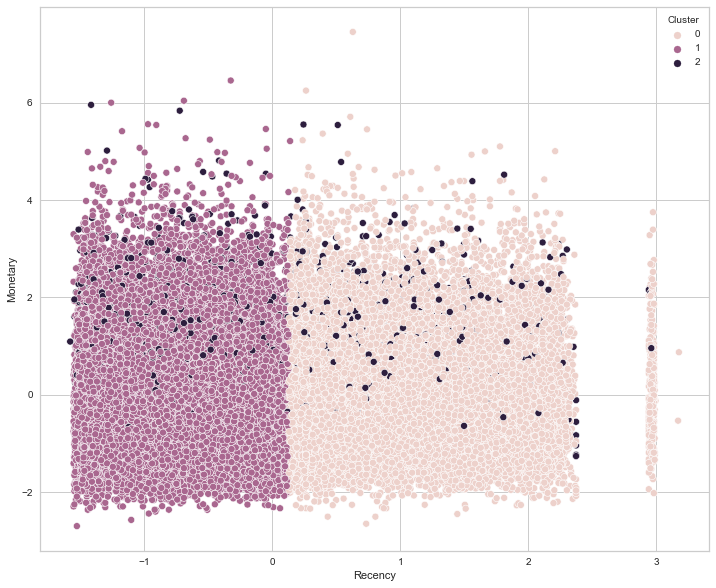

In [140]:
new = RFM_Table_scaled.copy()
new['Cluster'] = kmean_model_3.labels_

plt.figure(figsize=(12,10))
sns.scatterplot(data=new, x="Recency", y="Monetary",hue="Cluster")

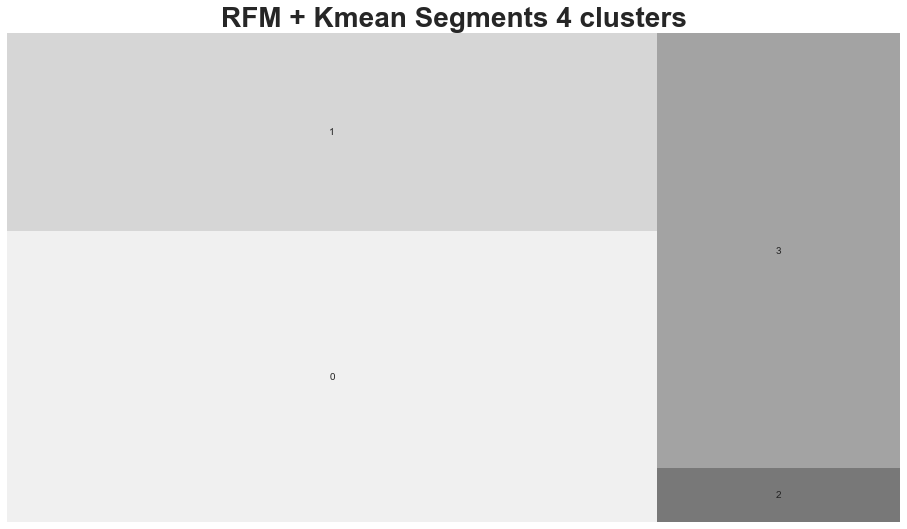

In [141]:
rfm_df_4 = rfm_df.copy()


# 4 clusters
kmean_model_4 = KMeans(n_clusters=4, random_state=5)
kmean_y_4 = kmean_model_4.fit_predict(RFM_Table_scaled)
# Add labels to df
rfm_df_4['Cluster'] = kmean_model_4.labels_

FMCG_rfm_level_agg2  = rfm_df_4.groupby(['Cluster']).agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': ['mean', 'count']
        }).round(0)

FMCG_rfm_level_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=FMCG_rfm_level_agg2['Count'], 
              label=['0',
                     '1',
                     '2',
                     '3',
                     '4',], alpha=.6 )
plt.title("RFM + Kmean Segments 4 clusters",fontsize=28,fontweight="bold")
plt.axis('off')
plt.show()

<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

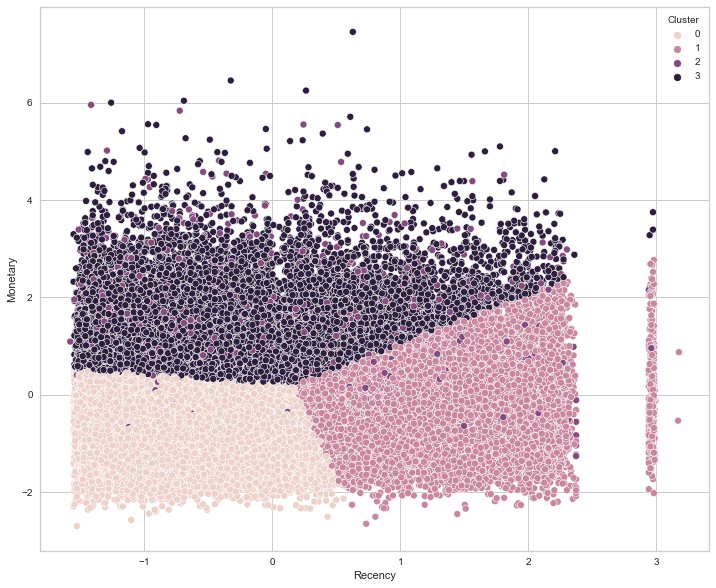

In [142]:
new = RFM_Table_scaled.copy()
new['Cluster'] = kmean_model_4.labels_

plt.figure(figsize=(12,10))
sns.scatterplot(data=new, x="Recency", y="Monetary",hue="Cluster")

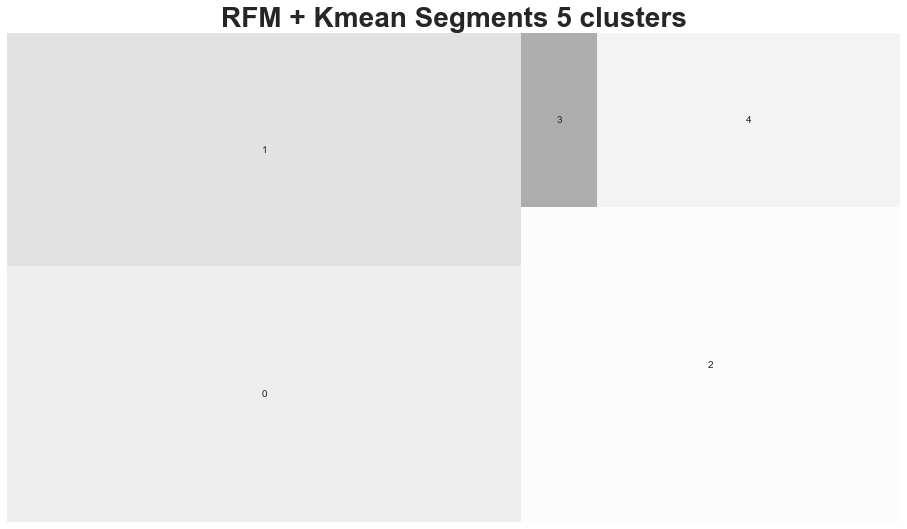

In [267]:
rfm_df_5 = rfm_df.copy()


# 4 clusters
kmean_model_5 = KMeans(n_clusters=5, random_state=5)
kmean_y_5 = kmean_model_5.fit_predict(RFM_Table_scaled)
# Add labels to df
rfm_df_5['Cluster'] = kmean_model_5.labels_

FMCG_rfm_level_agg2  = rfm_df_5.groupby(['Cluster']).agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': ['mean', 'count']
        }).round(0)

FMCG_rfm_level_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=FMCG_rfm_level_agg2['Count'], 
              label=['0',
                     '1',
                     '2',
                     '3',
                     '4',], alpha=.6 )
plt.title("RFM + Kmean Segments 5 clusters",fontsize=28,fontweight="bold")
plt.axis('off')
plt.show()

<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

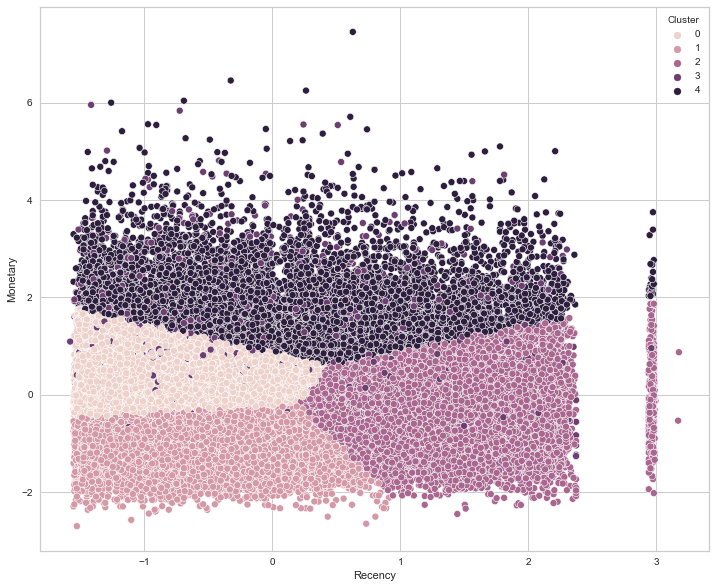

In [268]:
new = RFM_Table_scaled.copy()
new['Cluster'] = kmean_model_5.labels_

plt.figure(figsize=(12,10))
sns.scatterplot(data=new, x="Recency", y="Monetary",hue="Cluster")

In [143]:
rfm_values(rfm_df_4)


Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         145.0       1.0     82.0  40419
1         425.0       1.0    123.0  27551
2         226.0       2.0    488.0   2807
3         197.0       1.0    524.0  22619

In [144]:
RFM_km = pd.concat([RFM, pd.Series(kmean_model_4.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']
RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [302]:
RFM_km_DB = RFM_km.drop(['CustomerID'], axis=1)


In [145]:
RFM_km.ClusterID.value_counts()

0.0    40419
1.0    27551
3.0    22619
2.0     2807
Name: ClusterID, dtype: int64

In [146]:

# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(kmean_model_4.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [147]:
df = pd.concat([pd.Series([0,1,2,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4 entries, 0.0 to 3.0
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ClusterID       4 non-null      int64  
 1   Amount_mean     4 non-null      float64
 2   Frequency_mean  4 non-null      float64
 3   Recency_mean    4 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 160.0 bytes


<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

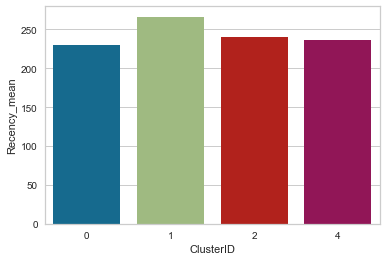

In [148]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

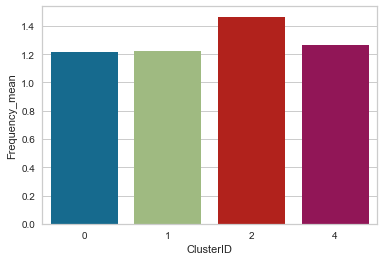

In [149]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Amount_mean'>

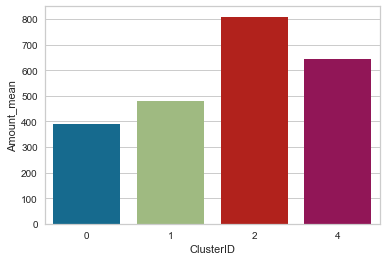

In [281]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

## DBSCAN

In [270]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [296]:
RFM_db = RFM.drop(['CustomerID'], axis=1)

In [307]:
RFM_km_DB

,Frequency,Amount,Recency,ClusterID
0,1,153.90,116,0.0
1,1,35.48,119,0.0
2,1,103.44,542,1.0
3,1,61.25,326,1.0
4,1,213.78,293,3.0
...,...,...,...,...
93504,2,8767.10,452,NaN
93505,1,104.27,267,NaN
93506,1,135.02,573,NaN
93507,1,152.38,124,NaN


In [308]:
RFM_km_DB = RFM_km_DB.drop(['ClusterID'], axis=1)

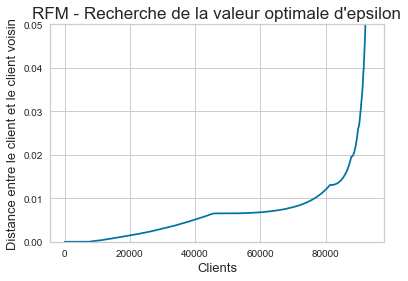

In [315]:
# Calcul des distances avec les plus proches voisins
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(RFM_Table_scaled)
distances, indices = nbrs.kneighbors(RFM_Table_scaled)

# Graphiquement
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.title("RFM - Recherche de la valeur optimale d'epsilon",
          fontsize=17)
plt.xlabel("Clients", fontsize=13)
plt.ylabel("Distance entre le client et le client voisin", fontsize=13)
plt.ylim(0, 0.05)
plt.plot(distances)

In [316]:
# On teste plusieurs valeurs de "min_samples"
for value in [5, 10, 15, 20, 25, 50, 100]:
    dbscan = DBSCAN(eps=0.01, min_samples=value)
    dbscan.fit(RFM_Table_scaled)
    y = dbscan.fit_predict(RFM_Table_scaled)

    # On regarde nos clusters
    RFM_Table_scaled['cluster_db'] = y

    # On regarde le nombre de noisy samples
    noisy_samples = RFM_Table_scaled['cluster_db'].value_counts()[-1]
    pourcentage = noisy_samples / df.shape[0] * 100

    print(f'Nombre de clusters (min_samples = {value}) :',
          RFM_Table_scaled['cluster_db'].nunique())
    print('Noisy samples :', noisy_samples)
    print('En pourcentage du DataFrame:', round(pourcentage, 2), '%\n')

Nombre de clusters (min_samples = 5) : 3307
Noisy samples : 46054
En pourcentage du DataFrame: 1151350.0 %

Nombre de clusters (min_samples = 10) : 649
Noisy samples : 81652
En pourcentage du DataFrame: 2041300.0 %

Nombre de clusters (min_samples = 15) : 109
Noisy samples : 90762
En pourcentage du DataFrame: 2269050.0 %

Nombre de clusters (min_samples = 20) : 20
Noisy samples : 92707
En pourcentage du DataFrame: 2317675.0 %

Nombre de clusters (min_samples = 25) : 8
Noisy samples : 93026
En pourcentage du DataFrame: 2325650.0 %

Nombre de clusters (min_samples = 50) : 2
Noisy samples : 93303
En pourcentage du DataFrame: 2332575.0 %

Nombre de clusters (min_samples = 100) : 1
Noisy samples : 93396
En pourcentage du DataFrame: 2334900.0 %



In [314]:
RFM_km_DB.cluster.value_counts()

-1     93160
 11       18
 10       17
 23       14
 2        12
 20       11
 49       10
 14       10
 9        10
 18        9
 8         8
 35        7
 19        7
 16        7
 12        7
 37        7
 5         7
 47        7
 22        7
 33        6
 40        6
 27        6
 46        6
 0         6
 25        6
 7         6
 21        6
 50        6
 17        5
 28        5
 1         5
 48        5
 3         5
 4         5
 45        5
 44        5
 43        5
 42        5
 41        5
 6         5
 39        5
 38        5
 26        5
 36        5
 13        5
 34        5
 15        5
 32        5
 31        5
 30        5
 29        5
 24        5
Name: cluster, dtype: int64

In [311]:
# On choisit un "min_samples" de 5
dbscan = DBSCAN(eps=0.01, min_samples=5)
dbscan.fit(RFM_km_DB)
y = dbscan.fit_predict(RFM_km_DB)

# On crée notre colonne de clusters
RFM_km_DB['cluster'] = y

In [ ]:
clusters_dbscan_rfm = dbscan.labels_

fig, ax = plt.subplots(3, figsize=(8, 15))
fig.tight_layout(pad=5.0)

# X: recence, Y: montant_total
ax[0].set_ylim(0, 3000)
ax[0].set_title(
    "DBSCAN - RFM : récence d'achat vs montant total des commandes",
    fontsize=17)
ax[0].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[0].set_ylabel("Montant total des commandes (R$)", fontsize=13)

fig1 = ax[0].scatter(.iloc[:, 4], df.iloc[:, 5],
                     c=clusters_dbscan_rfm, cmap='jet', alpha=0.2)

ax[0].legend(*fig1.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: frequence_achat
ax[1].set_title(
    "DBSCAN - RFM : récence d'achat vs fréquence d'achat",
    fontsize=17)
ax[1].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[1].set_ylabel("Fréquence d'achat", fontsize=13)
fig2 = ax[1].scatter(df.iloc[:, 4], df.iloc[:, 6],
                     c=clusters_dbscan_rfm, cmap='jet', alpha=0.2)

ax[1].legend(*fig2.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: montant_total, Y: frequence_achat
ax[2].set_xlim(0, 4000)
ax[2].set_title(
    "DBSCAN - RFM : montant total des commandes vs fréquence d'achat",
    fontsize=17)
ax[2].set_xlabel("Montant total des commandes (R$)", fontsize=13)
ax[2].set_ylabel("Fréquence d'achat", fontsize=13)

fig3 = ax[2].scatter(df.iloc[:, 5], df.iloc[:, 6],
                     c=clusters_dbscan_rfm, cmap='jet', alpha=0.2)

ax[2].legend(*fig3.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

plt.show()

## PCA + Kmean

In [236]:
data_num.head(1)

,payment_value,review_score,freight_value,nb_order,heure_achat,jour_achat,Total_Payment
0,141.9,5.0,12.0,1,10,3,153.9


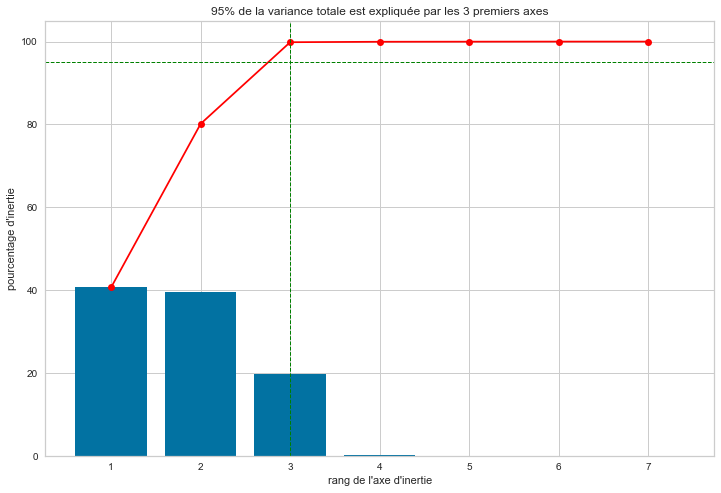

In [261]:
X_bis = data_num.copy()
#X_bis=X_bis.drop(['kmeans_label'], axis=1)
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X_bis)
X_projected = pca.transform(X_bis)

# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

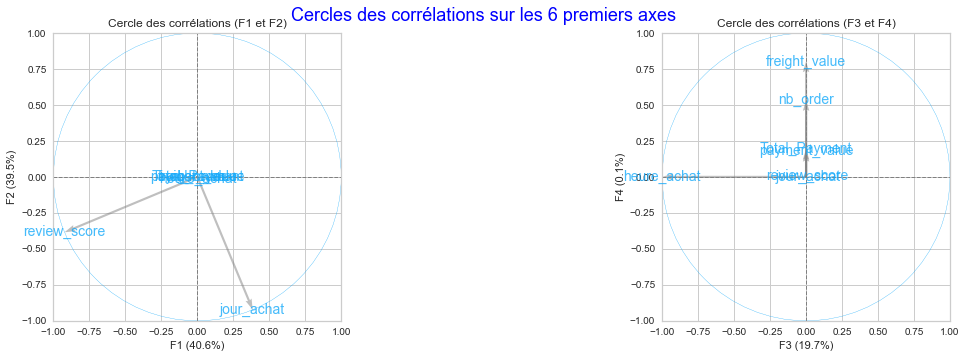

In [262]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*3))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)
    
    # Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           6,
           pca.named_steps['pca'],
           [(0,1),(2,3)],
           labels = np.array(X_bis.columns))

In [263]:
X_projected

array([[-1.91172786e-01, -1.20752892e-01,  2.09784669e-01, ...,
        -1.23049906e-03,  9.37362034e-04,  2.37137332e-17],
       [-1.52804300e-01,  4.36275911e-01,  1.58494591e-01, ...,
        -1.99550497e-03, -3.20872873e-04,  2.17208851e-18],
       [ 3.34801864e-01, -8.89082060e-02, -2.68599426e-01, ...,
         4.96415978e-04, -2.93751407e-04, -2.66173269e-17],
       ...,
       [-3.19269867e-01,  1.83831745e-01, -1.20028937e-02, ...,
         2.02250563e-03, -2.42446224e-04,  7.56012366e-18],
       [-2.55141933e-01,  3.00119120e-02, -9.79399965e-03, ...,
         7.88890733e-04,  3.26582934e-04,  1.01209944e-17],
       [-3.19129623e-01,  1.80768410e-01, -2.29372555e-01, ...,
        -3.84555202e-04, -1.27165934e-04, -1.67921961e-18]])

KElbowVisualizer(ax=<AxesSubplot:>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(1, 10),
                 timings=False)

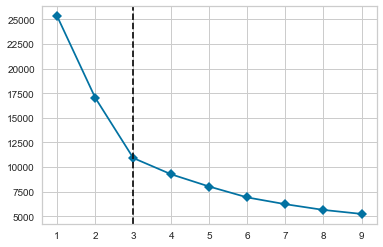

In [264]:
#pca = PCA().fit(data_num_std)
#scores_pca =pca.transform(data_num_std)
kmeans_pca = KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans_pca.fit(X_projected)
from yellowbrick.cluster import KElbowVisualizer

coude = KElbowVisualizer(kmeans_pca, k=(1,10), metric='distortion', timings=False)

coude.fit(X_projected)

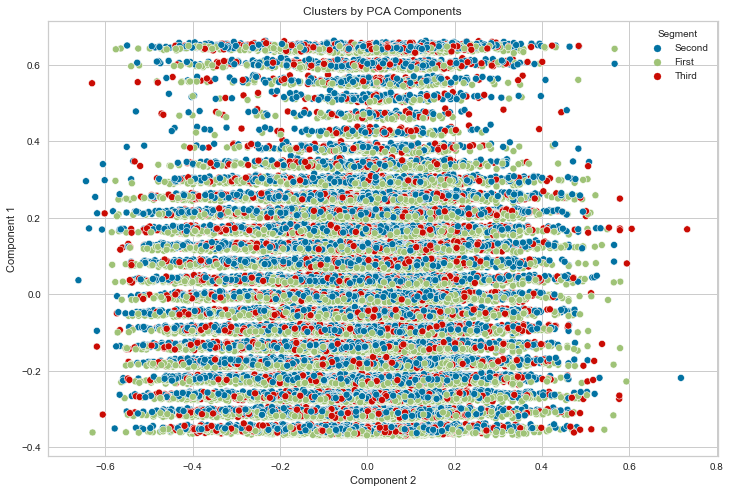

In [266]:
kmeans_pca_5 = KMeans(n_clusters=3,max_iter=3000000000, init='k-means++',random_state=42)
kmeans_pca_5.fit(X_projected)

data_num_pca_kmean_5 = pd.concat([data_num.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
data_num_pca_kmean_5.columns.values[-4: ]= ["Component 1","Component 2","Component 3","Component 4"]
data_num_pca_kmean_5['Segment K-means PCA'] = kmeans_pca_5.labels_

data_num_pca_kmean_5['Segment'] = data_num_pca_kmean_5['Segment K-means PCA'].map({0:'First',
                                                                               1:'Second',
                                                                               2:'Third',
                                                                               
    
})


x_axis =data_num_pca_kmean_5['Component 2']
y_axis = data_num_pca_kmean_5['Component 1']

plt.figure(figsize=(12,8))
sns.scatterplot(x_axis,y_axis,hue=data_num_pca_kmean_5['Segment'])
plt.title('Clusters by PCA Components')
plt.show()

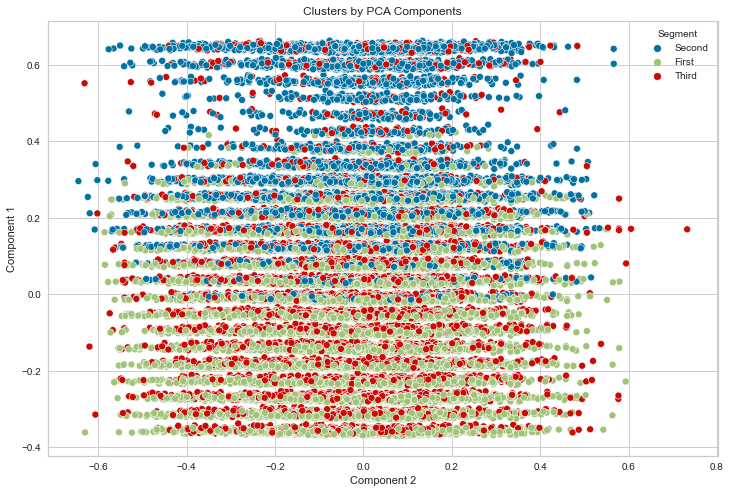

In [317]:
kmeans_pca_5 = KMeans(n_clusters=4,max_iter=3000, init='k-means++',random_state=42)
kmeans_pca_5.fit(X_projected)

data_num_pca_kmean_5 = pd.concat([data_num.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
data_num_pca_kmean_5.columns.values[-4: ]= ["Component 1","Component 2","Component 3","Component 4"]
data_num_pca_kmean_5['Segment K-means PCA'] = kmeans_pca_5.labels_

data_num_pca_kmean_5['Segment'] = data_num_pca_kmean_5['Segment K-means PCA'].map({0:'First',
                                                                               1:'Second',
                                                                               2:'Third',
                                                                               4:'Four'
                                                                               
    
})


x_axis =data_num_pca_kmean_5['Component 2']
y_axis = data_num_pca_kmean_5['Component 1']

plt.figure(figsize=(12,8))
sns.scatterplot(x_axis,y_axis,hue=data_num_pca_kmean_5['Segment'])
plt.title('Clusters by PCA Components')
plt.show()

## Linkage

In [257]:
# standardise all parameters
RFM_norm1 = RFM.drop(["CustomerID"], axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

_ = pd.DataFrame(RFM_norm1)

from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd

#10% des données avec moyenne pondéré 
weighted_sample = _.sample(n=8157)

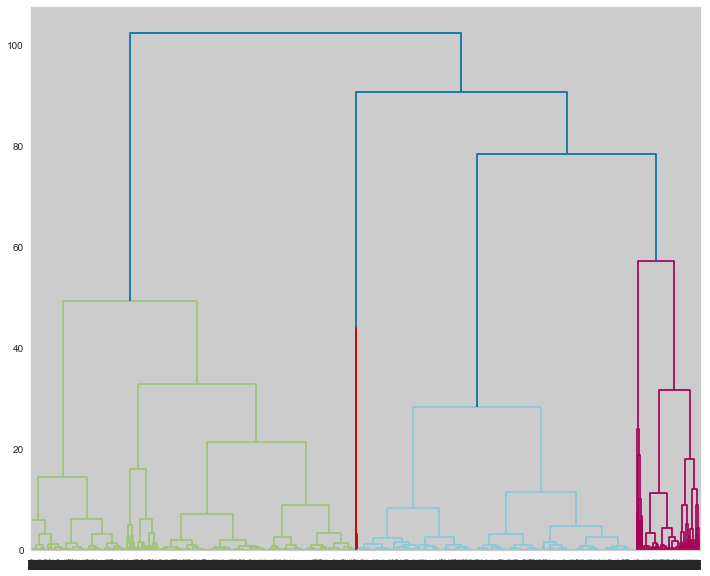

In [258]:

plt.figure(figsize=(12,10))
mergings = linkage(weighted_sample, method = "ward", metric='euclidean')
dendrogram(mergings)

plt.show()

## RFM analyse

In [ ]:
rfm_df_df = rfm_df.copy()
rfm_df_df.Frequency.value_counts()

In [ ]:
rfm_df_df["Recency_Score"]  = pd.qcut(rfm_df_df['Recency'], 5, [5, 4, 3, 2, 1])
rfm_df_df["Frequency_Score"]  = pd.qcut(rfm_df_df['Frequency'].rank(method="first"), 5, [1, 2, 3, 4, 5])
rfm_df_df["Monetary_Score"]  = pd.qcut(rfm_df_df['Monetary'], 5, [1, 2, 3, 4, 5])

In [ ]:
rfm_df_df["RFM_SCORE"] = (rfm_df_df['Recency_Score'].astype(str) +
                    rfm_df_df['Frequency_Score'].astype(str))

rfm_df_df.head() 

In [ ]:
rfm_df_df['Segment'] = rfm_df_df['RFM_SCORE']
rfm_df_df.head()

In [ ]:
rfm_df_df.RFM_SCORE.value_counts()

In [ ]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

In [ ]:
rfm_df_df['Segment'] = rfm_df_df['Segment'].replace(seg_map, regex=True)
rfm_df_df.reset_index(inplace=True)
rfm_df_df.head()

In [ ]:
rfm_df_df.groupby('Segment').agg({"customer_unique_id":"count"}).sort_values("customer_unique_id",ascending=False)

In [ ]:
# count the number of customers in each segment
segments_counts = rfm_df_df['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='blue')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()